In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.utils.np_utils import to_categorical  
from keras import regularizers
from keras.utils.np_utils import to_categorical

from constants import num_class

Using TensorFlow backend.


## Callbacks

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')
            
checkpoint = keras.callbacks.ModelCheckpoint(
    './convnet_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=True, 
    mode='auto', 
    period=1,
)

## Data

In [3]:
train_labels = to_categorical(np.load('./features/res_net/classes_train.npy'))
dev_labels = to_categorical(np.load('./features/res_net/classes_dev.npy'))

In [4]:
train_data_1 = np.load('./features/res_net/features_train.npy')
dev_data_1 = np.load('./features/res_net/features_dev.npy')

In [5]:
train_data_2 = np.load('./features/inception/features_train.npy')
dev_data_2 = np.load('./features/inception/features_dev.npy')

In [6]:
train_data_3 = np.load('./features/xception/features_train.npy')
dev_data_3 = np.load('./features/xception/features_dev.npy')

In [7]:
train_data = np.concatenate([train_data_1, train_data_2, train_data_3], axis=1)
dev_data = np.concatenate([dev_data_1, dev_data_2, dev_data_3], axis=1)
train_data_1 = None
train_data_2 = None
train_data_3 = None
dev_data_1 = None
dev_data_2 = None
dev_data_3 = None

## Top Model

In [8]:
def model(train_data, dev_data, lr = 0.00001):
    inputs = Input(shape=(train_data.shape[1:]))
    X = Dropout(0.5)(inputs)
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(2048, activation='relu')(X)
    X = Dense(2048, activation='relu')(X)
    X = Dense(1024, activation='relu')(X)

    outputs = Dense(
        num_class, 
        activation='softmax', 
        #activity_regularizer=regularizers.l2(100.)
    )(X)

    top_model = Model(inputs=inputs, outputs=outputs)

    top_model.compile(optimizer=tf.train.AdamOptimizer(lr),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    
    return top_model

## Concatenation

In [9]:
plot_losses = PlotLosses()
top_model = model(train_data, dev_data, 0.00001)

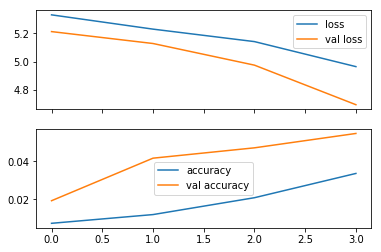

Epoch 1
-----------------------
- Loss: 5.33273398558
- Accuracy: 0.00745804847732
- Validation loss: 5.21330607495
- Validation accuracy: 0.0193178388168
 
Epoch 2
-----------------------
- Loss: 5.23089479259
- Accuracy: 0.0120416407712
- Validation loss: 5.12835142197
- Validation accuracy: 0.0416540899453
 
Epoch 3
-----------------------
- Loss: 5.14192929455
- Accuracy: 0.0208980733381
- Validation loss: 4.97400032067
- Validation accuracy: 0.0470872321137
 
Epoch 4
-----------------------
- Loss: 4.96349051104
- Accuracy: 0.0336389061529
- Validation loss: 4.69187981867
- Validation accuracy: 0.054633262897
 
Epoch 5/50
11520/12872 [=========================>....] - ETA: 4s - loss: 4.6979 - categorical_accuracy: 0.0442

In [ ]:
#top_model.load_weights('./model_1/weights.03-0.53.hdf5')

top_model.fit(
    train_data, train_labels,
    batch_size=128,
    epochs=50,
    callbacks=[plot_losses, checkpoint], 
    validation_data=(dev_data, dev_labels),
)

## Averaging

In [ ]:
plot_losses = PlotLosses()
top_model_1 = model(train_data_1, dev_data_1, 0.00001)

In [ ]:
#top_model.load_weights('./model_1/weights.50-10.92.hdf5')

top_model_1.fit(
    train_data_1, train_labels,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[plot_losses, checkpoint], 
    validation_data=(dev_data_1, dev_labels),
)

In [ ]:
plot_losses = PlotLosses()
top_model_2 = model(train_data_2, dev_data_2, 0.00001)

In [ ]:
#top_model.load_weights('./model_1/weights.50-10.92.hdf5')

top_model_2.fit(
    train_data_2, train_labels,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[plot_losses, checkpoint], 
    validation_data=(dev_data_2, dev_labels),
)

### Predictions

In [5]:
real_classes = np.load('./data/bottleneck_features/res_net/classes.npy')
real_classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int32)

In [11]:
top_model_1.load_weights('./best_models/weights.13-2.82.hdf5')
predictions_1 = top_model_1.predict(dev_data_1)

In [ ]:
top_model_2.load_weights('./best_models/weights.13-2.82.hdf5')
predictions_2 = top_model_2.predict(dev_data_2)

In [ ]:
predictions = np.stack([predictions_1, predictions_2], axis=0)
#predictions = np.max(predictions, axis=0)
predictions = np.mean(predictions, axis=0)

In [12]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([  0,   0,   0, ..., 119, 111,   6])

In [13]:
filenames = np.load('./data/bottleneck_features/vgg16/filenames.npy')

In [14]:
predictions_df = pd.DataFrame({
    "filenames": filenames,
    "real": real_classes,
    "predictions": predicted_classes
})

In [15]:
wrong_answers = predictions_df[predictions_df['real'] != predictions_df['predictions']]
wrong_answers.shape

(380, 3)

In [31]:
wrong_answers['real'].value_counts()[0:10]

71     8
102    8
59     6
106    6
60     6
89     6
90     6
76     6
101    6
73     6
Name: real, dtype: int64

In [29]:
predictions_df[predictions_df['real'] == 71]['real'].value_counts()

71    9
Name: real, dtype: int64

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


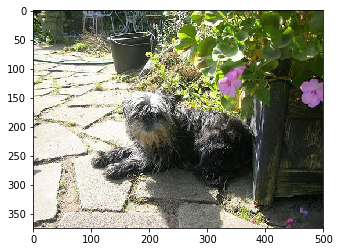

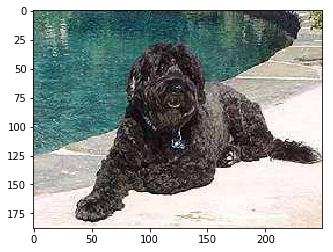

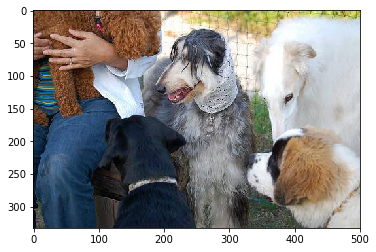

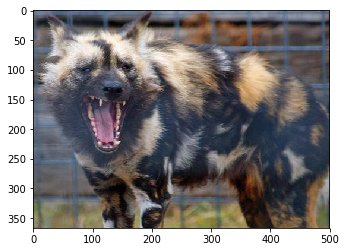

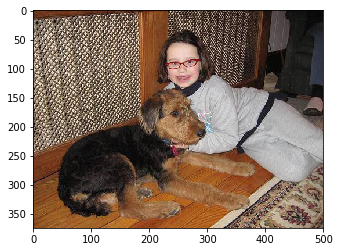

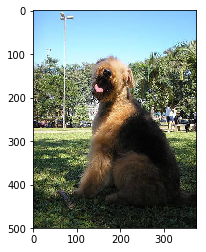

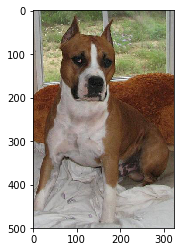

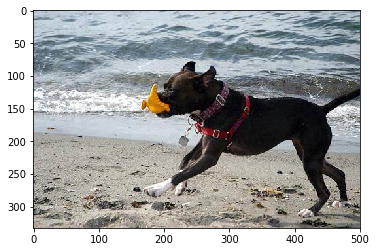

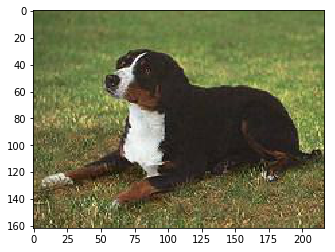

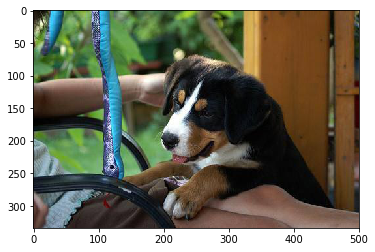

In [20]:
for filename in wrong_answers['filenames'][0:10]:
    image = np.array(ndimage.imread('./data/dev_dataset/' + filename, flatten=False))
    plt.figure()
    plt.imshow(image)